# Image Classification of the Pet Breeds Using the Oxford-IIIT Pet Dataset

Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

### Setting up Libraries

In [30]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import time
import copy
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Checking for the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

Using device: cuda



Importing all the necessary libraries that I am using in the code. Setting manual seed so the code is reproducible and the results wont change every time the code is ran. Setting device to GPU for better performance.  

### Full Dataset Loading Function

In [31]:
class FullOxfordPetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_dir = os.path.join(root, 'images')
        list_file = os.path.join(root, 'annotations', 'list.txt')

        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Skip header lines in our txt file
        with open(list_file, 'r') as f:
            lines = f.readlines()[6:]

        for line in lines:
            parts = line.strip().split()
            filename = parts[0] + ".jpg"
            label = int(parts[1]) - 1  # label is 0-based

            # Extract class name from the filename
            breed_name = parts[0].rsplit('_', 1)[0].lower()

            # Building class mappings
            if label not in self.idx_to_class:
                self.idx_to_class[label] = breed_name
            if breed_name not in self.class_to_idx:
                self.class_to_idx[breed_name] = label

            self.samples.append((filename, label))

        # Final class list in order
        self.classes = [self.idx_to_class[i] for i in sorted(self.idx_to_class.keys())]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        image_path = os.path.join(self.image_dir, filename)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

Here i have written a function to access the dataset from annotations folder in dataset I am using the list.txt file which contains all the labels of classes in our dataset. It helps to load the images and their corresponding labels. For each image, it extracts the label and the breed name, and keeps track of the mapping between class names and numerical labels.

### Loading Dataset

In [32]:
# Using all 37 classes from the Oxford-IIIT Pet Dataset
NUM_CLASSES = 37

# Load the dataset (download if not already present)
dataset_path = './data/oxford-iiit-pet'
download_flag = not os.path.exists(dataset_path)
if download_flag:
    print("Downloading dataset...")
else:
    print("Dataset already exists, skipping download.")

# Loading full dataset with all 37 classes
full_dataset = FullOxfordPetDataset(root=dataset_path, transform=None)

class_names = full_dataset.classes
print(f"Total images in dataset: {len(full_dataset)}")
print(f"Number of classes: {len(class_names)}")

Dataset already exists, skipping download.
Total images in dataset: 7349
Number of classes: 37


I have total 37 classes of pets in my dataset. For the Training and Prediction I will be using all classes. Setting the dataset to download if not already downloaded otherwise skip. I have printed the all the classes in the dataset

In [33]:
from collections import Counter

# Count the number of labels that are per class
labels = [label for _, label in full_dataset]
class_counts = Counter(labels)
print("The number of images per class are:")
for idx, count in sorted(class_counts.items()):
    print(f"{class_names[idx]}: {count} images")

The number of images per class are:
abyssinian: 198 images
american_bulldog: 200 images
american_pit_bull_terrier: 200 images
basset_hound: 200 images
beagle: 200 images
bengal: 200 images
birman: 200 images
bombay: 184 images
boxer: 199 images
british_shorthair: 200 images
chihuahua: 200 images
egyptian_mau: 190 images
english_cocker_spaniel: 196 images
english_setter: 200 images
german_shorthaired: 200 images
great_pyrenees: 200 images
havanese: 200 images
japanese_chin: 200 images
keeshond: 199 images
leonberger: 200 images
maine_coon: 200 images
miniature_pinscher: 200 images
newfoundland: 196 images
persian: 200 images
pomeranian: 200 images
pug: 200 images
ragdoll: 200 images
russian_blue: 200 images
saint_bernard: 200 images
samoyed: 200 images
scottish_terrier: 199 images
shiba_inu: 200 images
siamese: 199 images
sphynx: 200 images
staffordshire_bull_terrier: 189 images
wheaten_terrier: 200 images
yorkshire_terrier: 200 images


Here it shows the total number of labels per class we have in our dataset. Which shows our dataset is balanced almost each class have 200 image except some have less than 200 images

### Data Preprocessing

In [34]:
# Defining transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Spliting dataset into training 70%, validation 15%  and testing 15%
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_indices, val_indices, test_indices = random_split(
    range(len(full_dataset)), [train_size, val_size, test_size]
)

# Dataset wrapper for transforms
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, indices, transform=None):
        self.subset = subset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        image, label = self.subset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.indices)

# Creating datasets
train_dataset = TransformSubset(full_dataset, train_indices, transform=train_transform)
val_dataset = TransformSubset(full_dataset, val_indices, transform=val_test_transform)
test_dataset = TransformSubset(full_dataset, test_indices, transform=val_test_transform)

# Creating data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training set size: {len(train_dataset)} images")
print(f"Validation set size: {len(val_dataset)} images")
print(f"Test set size: {len(test_dataset)} images\n")

Training set size: 5144 images
Validation set size: 1102 images
Test set size: 1103 images



I have created a transform pipeline for my data set, first is train data tranform pipeline I have resized the shorter edge to 256 so it maintains the aspect ratio and standardizing the images makes it easir to process with CNNs. Then random crop of 224 it randomly takes 224 * 224 crops of image which encourages the model to focus on different parts of the pet in different epochs it add robustness and generalization. For example in each epoch the model will have different part to focus on like one crop might center the face, another might crop near the tail this makes the model learn more general features. Adding RandomHorizontalFlip for data diversity. RandomRotation rotates the image randomly by up to ± 15 degrees so it helps model learn rotation invariant features. Finally convert the PIL image to pytorch tensor. And then adding channel wise normalization so we adjust brightness (mean) and contrast (std) to match ResNets training environment.
Transformsubset is used for the subset of classes that we are using. Transforms are applied at the time of access not during split and it allows the same image to be transformed differently in each epoch.

### Visualizing Sample Images

Visualizing the sample training images:


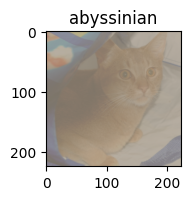

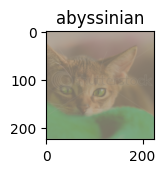

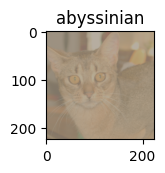

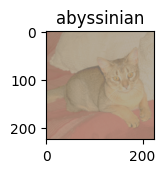

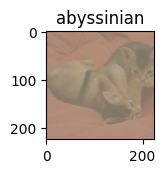

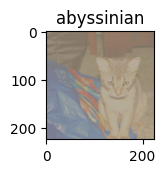

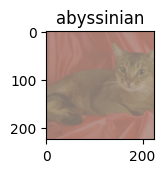

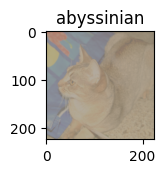

Saved sample images to 'sample_images.png'



<Figure size 640x480 with 0 Axes>

In [35]:
# Sample Visualization
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

print("Visualizing the sample training images:")

sample_transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])

# Creating  a new figure
plt.figure(figsize=(8, 6))

# Ploting image
for i, idx in enumerate(range(8)):
    img, label = full_dataset[idx]
    img_t = sample_transform(img)
    
    # Creating the subplot
    ax = plt.subplot(2, 4, i+1)
    imshow(img_t, title=class_names[label])
    
    # Removing the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('sample_images.png')
print("Saved sample images to 'sample_images.png'\n")
plt.show()

Here I have visualized sample of images first did some conversion so the image is accepted by matplotlib and also applied the tranforms to see the sample images.

### Defining CNN Model

In [9]:
# Defining CNN Model
class PetClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(PetClassifierCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)) 
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),             
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initializing the model
custom_cnn = PetClassifierCNN(NUM_CLASSES).to(device)
print("CNN Model Architecture:")
print(custom_cnn)

CNN Model Architecture:
PetClassifierCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

I have used 4 convolutional layers which provide enough depth to learn the features of our data set. Used BatchNorm which improves the stability of the model by normalizing activations across the batch, it helps in faster convergence and reduces the chances of overfitting. Relu activation function is used it applies non linearity and helps model to learn complex non linear features. Relu keeps only positive values. Using MaxPooling to reduce spatial size and computation. Towards the end i am using AdaptiveAvgPool2d which makes the network independent of spatial size and drastically reduces parameters before they enter the classifier.

In the classifier head i am using drop out 0.5 which drops 50% of the unit to reduce overfitting.

### Defining ResNet18 Model (Transfer Learning)

In [36]:
# ResNet18 Model
def initialize_resnet(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Initializing the model
resnet = initialize_resnet(NUM_CLASSES).to(device)
print("\nResNet Model Architecture:")
print(resnet)


ResNet Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

Loading the pre trained ResNet18 model. Freezing all the layers so the weights doesnt update because it already trained on best weights. Lastly replacing the final layer to output my data sets target number of classes.

### Defining ResNet34 Model (Transfer Learning)

In [37]:
# ResNet34 Model
def initialize_resnet34(num_classes):
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Initialize ResNet34
resnet34 = initialize_resnet34(NUM_CLASSES).to(device)
print("\nResNet34 Model Architecture:")
print(resnet34)


ResNet34 Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Loading the pre trained ResNet34 model. Freezing all the layers so the weights doesnt update because it already trained on best weights. Lastly replacing the final layer to output my data sets target number of classes.

### Defining ResNet50 Model (Transfer Learning)

In [38]:
# ResNet50 Model
def initialize_resnet50(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Initialize ResNet50
resnet50 = initialize_resnet50(NUM_CLASSES).to(device)
print("\nResNet50 Model Architecture:")
print(resnet50)


ResNet50 Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

Loading the pre trained ResNet50 model. Freezing all the layers so the weights doesnt update because it already trained on best weights. Lastly replacing the final layer to output my data sets target number of classes.

### Traning Model

In [39]:
# Training Function
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=30):
    print(f"\nTraining {model_name} model...")
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        loop = tqdm(train_loader, desc=f"Training")
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            loop.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Validation")
            for inputs, labels in val_loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_loop.set_postfix(loss=loss.item())
        
        val_epoch_loss = val_loss / len(val_dataset)
        val_epoch_acc = val_corrects.double() / len(val_dataset)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} | Acc: {val_epoch_acc:.4f}')
        
        # Early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving model...")
        else:
            counter += 1
            print(f"No improvement for {counter}/{patience} epochs")
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
        
        scheduler.step()
    
    model.load_state_dict(best_model_wts)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()
    print(f"Saved training history to {model_name}_training_history.png")
    
    return model, history


In the training function it takes loss function, optimizer, learning rate scheduler, and number of epochs as inputs. The tarining alternates between training and validation phase for each epoch. In each epoch it trains the model on training data and validates on unseen validation data and calculate loss for both. Best upon those losses it improvises and improves it self. I have also added early stopping with patience of 5 if there is no improvemnt for 5 epoch it will stop, it saves computational power and also reduces the chance of overfitting. I have also used learning rate scheduling which adjdust learning rate over epoch to improve convergence.

### Training Custom CNN


Training Custom_CNN model...

Epoch 1/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.57it/s, loss=3.41]


Train Loss: 3.5412 | Acc: 0.0492
Val Loss: 3.4273 | Acc: 0.0554
Validation loss improved. Saving model...

Epoch 2/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.47it/s, loss=3.41]


Train Loss: 3.4174 | Acc: 0.0692
Val Loss: 3.3308 | Acc: 0.0853
Validation loss improved. Saving model...

Epoch 3/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.56it/s, loss=3.42]


Train Loss: 3.3467 | Acc: 0.0863
Val Loss: 3.2370 | Acc: 0.1034
Validation loss improved. Saving model...

Epoch 4/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.08it/s, loss=3.26]


Train Loss: 3.2744 | Acc: 0.1019
Val Loss: 3.1636 | Acc: 0.1162
Validation loss improved. Saving model...

Epoch 5/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.13it/s, loss=3.38]


Train Loss: 3.2043 | Acc: 0.1133
Val Loss: 3.1793 | Acc: 0.1116
No improvement for 1/5 epochs

Epoch 6/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.34it/s, loss=3.26]


Train Loss: 3.1289 | Acc: 0.1299
Val Loss: 3.0359 | Acc: 0.1461
Validation loss improved. Saving model...

Epoch 7/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.21it/s, loss=3.37]


Train Loss: 3.0577 | Acc: 0.1415
Val Loss: 3.0597 | Acc: 0.1434
No improvement for 1/5 epochs

Epoch 8/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.32it/s, loss=3.48]


Train Loss: 3.0222 | Acc: 0.1584
Val Loss: 2.9885 | Acc: 0.1633
Validation loss improved. Saving model...

Epoch 9/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.58it/s, loss=2.94]


Train Loss: 2.9605 | Acc: 0.1656
Val Loss: 2.7946 | Acc: 0.2078
Validation loss improved. Saving model...

Epoch 10/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.13it/s, loss=2.98]


Train Loss: 2.9012 | Acc: 0.1757
Val Loss: 2.8208 | Acc: 0.2123
No improvement for 1/5 epochs

Epoch 11/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.94it/s, loss=2.95]


Train Loss: 2.7769 | Acc: 0.2138
Val Loss: 2.6261 | Acc: 0.2613
Validation loss improved. Saving model...

Epoch 12/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.34it/s, loss=2.96]


Train Loss: 2.7219 | Acc: 0.2210
Val Loss: 2.5917 | Acc: 0.2713
Validation loss improved. Saving model...

Epoch 13/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.64it/s, loss=2.97]


Train Loss: 2.7082 | Acc: 0.2253
Val Loss: 2.5601 | Acc: 0.2641
Validation loss improved. Saving model...

Epoch 14/30
----------


Validation: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.56it/s, loss=3]


Train Loss: 2.6895 | Acc: 0.2309
Val Loss: 2.5427 | Acc: 0.2722
Validation loss improved. Saving model...

Epoch 15/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.16it/s, loss=2.99]


Train Loss: 2.6769 | Acc: 0.2302
Val Loss: 2.5629 | Acc: 0.2750
No improvement for 1/5 epochs

Epoch 16/30
----------


Validation: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.04it/s, loss=3]


Train Loss: 2.6745 | Acc: 0.2337
Val Loss: 2.5211 | Acc: 0.2813
Validation loss improved. Saving model...

Epoch 17/30
----------


Validation: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.18it/s, loss=3]


Train Loss: 2.6683 | Acc: 0.2308
Val Loss: 2.5059 | Acc: 0.2840
Validation loss improved. Saving model...

Epoch 18/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.70it/s, loss=3.04]


Train Loss: 2.6393 | Acc: 0.2364
Val Loss: 2.4919 | Acc: 0.2777
Validation loss improved. Saving model...

Epoch 19/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.28it/s, loss=3.08]


Train Loss: 2.6426 | Acc: 0.2405
Val Loss: 2.5122 | Acc: 0.2804
No improvement for 1/5 epochs

Epoch 20/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.42it/s, loss=3.06]


Train Loss: 2.6337 | Acc: 0.2463
Val Loss: 2.4829 | Acc: 0.2922
Validation loss improved. Saving model...

Epoch 21/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.99it/s, loss=3.01]


Train Loss: 2.6223 | Acc: 0.2500
Val Loss: 2.4656 | Acc: 0.2985
Validation loss improved. Saving model...

Epoch 22/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.04it/s, loss=3.03]


Train Loss: 2.5928 | Acc: 0.2494
Val Loss: 2.4629 | Acc: 0.3022
Validation loss improved. Saving model...

Epoch 23/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.25it/s, loss=3.02]


Train Loss: 2.6216 | Acc: 0.2475
Val Loss: 2.4692 | Acc: 0.2922
No improvement for 1/5 epochs

Epoch 24/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.48it/s, loss=3.03]


Train Loss: 2.6095 | Acc: 0.2560
Val Loss: 2.4608 | Acc: 0.2967
Validation loss improved. Saving model...

Epoch 25/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.85it/s, loss=2.99]


Train Loss: 2.6170 | Acc: 0.2504
Val Loss: 2.4562 | Acc: 0.2949
Validation loss improved. Saving model...

Epoch 26/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.05it/s, loss=3.01]


Train Loss: 2.5922 | Acc: 0.2547
Val Loss: 2.4609 | Acc: 0.3004
No improvement for 1/5 epochs

Epoch 27/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.97it/s, loss=3.03]


Train Loss: 2.5931 | Acc: 0.2531
Val Loss: 2.4598 | Acc: 0.2967
No improvement for 2/5 epochs

Epoch 28/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.39it/s, loss=3.01]


Train Loss: 2.5987 | Acc: 0.2461
Val Loss: 2.4533 | Acc: 0.3076
Validation loss improved. Saving model...

Epoch 29/30
----------


Validation: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.34it/s, loss=3]


Train Loss: 2.5892 | Acc: 0.2562
Val Loss: 2.4473 | Acc: 0.3031
Validation loss improved. Saving model...

Epoch 30/30
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.55it/s, loss=3.03]


Train Loss: 2.5979 | Acc: 0.2514
Val Loss: 2.4590 | Acc: 0.3013
No improvement for 1/5 epochs


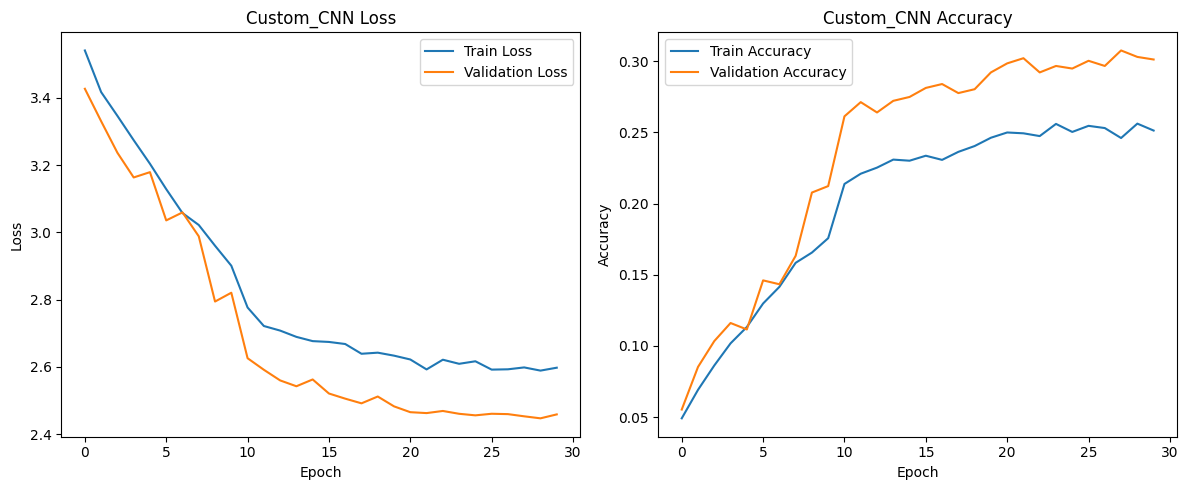

Saved training history to Custom_CNN_training_history.png
Saved Custom CNN model


In [15]:
# Training CNN Model
custom_cnn_optimizer = optim.Adam(custom_cnn.parameters(), lr=0.001)
custom_cnn_criterion = nn.CrossEntropyLoss()
custom_cnn_scheduler = optim.lr_scheduler.StepLR(custom_cnn_optimizer, step_size=10, gamma=0.1)

trained_cnn, cnn_history = train_model(
    custom_cnn, 
    "Custom_CNN",
    custom_cnn_criterion,
    custom_cnn_optimizer,
    custom_cnn_scheduler,
    num_epochs=30
)

# Save model
torch.save(trained_cnn.state_dict(), 'custom_cnn.pth')
print("Saved Custom CNN model")

### Training ResNet18


Training ResNet model...

Epoch 1/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.98it/s, loss=1.05]


Train Loss: 1.7799 | Acc: 0.5927
Val Loss: 0.8217 | Acc: 0.8140
Validation loss improved. Saving model...

Epoch 2/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  5.89it/s, loss=0.707]


Train Loss: 0.7338 | Acc: 0.8248
Val Loss: 0.5554 | Acc: 0.8575
Validation loss improved. Saving model...

Epoch 3/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.53it/s, loss=0.709]


Train Loss: 0.5534 | Acc: 0.8614
Val Loss: 0.4763 | Acc: 0.8630
Validation loss improved. Saving model...

Epoch 4/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.21it/s, loss=0.545]


Train Loss: 0.4793 | Acc: 0.8637
Val Loss: 0.4317 | Acc: 0.8639
Validation loss improved. Saving model...

Epoch 5/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.75it/s, loss=0.594]


Train Loss: 0.4295 | Acc: 0.8799
Val Loss: 0.4164 | Acc: 0.8784
Validation loss improved. Saving model...

Epoch 6/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.72it/s, loss=0.53]


Train Loss: 0.4083 | Acc: 0.8859
Val Loss: 0.3952 | Acc: 0.8702
Validation loss improved. Saving model...

Epoch 7/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.94it/s, loss=0.57]


Train Loss: 0.3750 | Acc: 0.8896
Val Loss: 0.3907 | Acc: 0.8739
Validation loss improved. Saving model...

Epoch 8/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.11it/s, loss=0.533]


Train Loss: 0.3263 | Acc: 0.9071
Val Loss: 0.3826 | Acc: 0.8793
Validation loss improved. Saving model...

Epoch 9/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.65it/s, loss=0.519]


Train Loss: 0.3312 | Acc: 0.9073
Val Loss: 0.3891 | Acc: 0.8757
No improvement for 1/5 epochs

Epoch 10/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.72it/s, loss=0.545]


Train Loss: 0.3219 | Acc: 0.9092
Val Loss: 0.3744 | Acc: 0.8884
Validation loss improved. Saving model...

Epoch 11/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.73it/s, loss=0.542]


Train Loss: 0.3182 | Acc: 0.9102
Val Loss: 0.3741 | Acc: 0.8848
Validation loss improved. Saving model...

Epoch 12/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.00it/s, loss=0.534]


Train Loss: 0.3182 | Acc: 0.9073
Val Loss: 0.3871 | Acc: 0.8784
No improvement for 1/5 epochs

Epoch 13/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.27it/s, loss=0.551]


Train Loss: 0.3281 | Acc: 0.9059
Val Loss: 0.3757 | Acc: 0.8829
No improvement for 2/5 epochs

Epoch 14/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.60it/s, loss=0.522]


Train Loss: 0.3235 | Acc: 0.9079
Val Loss: 0.3746 | Acc: 0.8866
No improvement for 3/5 epochs

Epoch 15/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.61it/s, loss=0.589]


Train Loss: 0.3286 | Acc: 0.9051
Val Loss: 0.3599 | Acc: 0.8838
Validation loss improved. Saving model...

Epoch 16/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.05it/s, loss=0.516]


Train Loss: 0.3167 | Acc: 0.9129
Val Loss: 0.3683 | Acc: 0.8829
No improvement for 1/5 epochs

Epoch 17/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.08it/s, loss=0.502]


Train Loss: 0.3112 | Acc: 0.9145
Val Loss: 0.3734 | Acc: 0.8829
No improvement for 2/5 epochs

Epoch 18/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.76it/s, loss=0.534]


Train Loss: 0.3129 | Acc: 0.9156
Val Loss: 0.3658 | Acc: 0.8793
No improvement for 3/5 epochs

Epoch 19/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.54it/s, loss=0.51]


Train Loss: 0.2976 | Acc: 0.9182
Val Loss: 0.3771 | Acc: 0.8811
No improvement for 4/5 epochs

Epoch 20/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.11it/s, loss=0.571]


Train Loss: 0.3188 | Acc: 0.9114
Val Loss: 0.3627 | Acc: 0.8829
No improvement for 5/5 epochs
Early stopping after 20 epochs


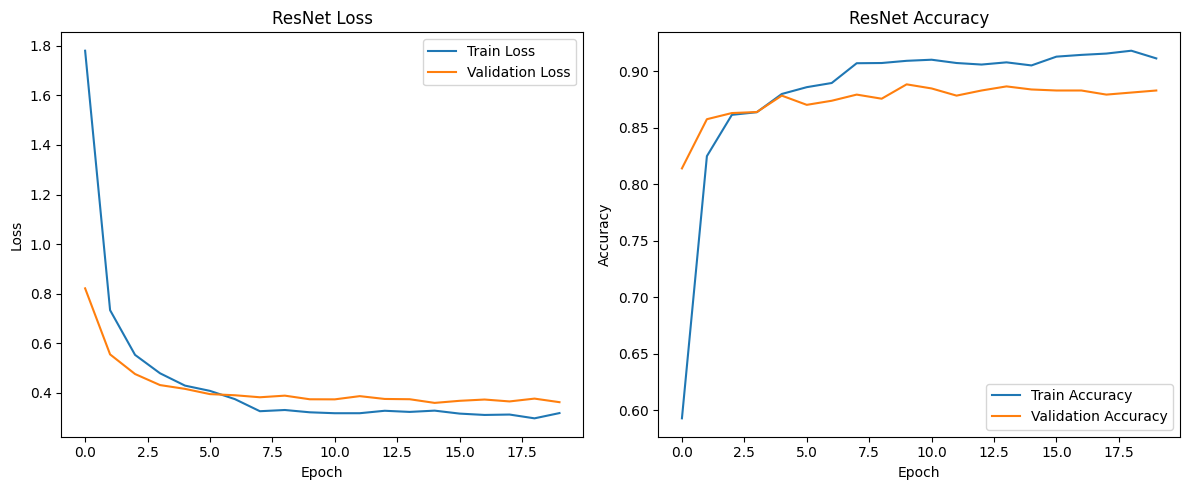

Saved training history to ResNet_training_history.png
Saved ResNet model


In [40]:
# Training ResNet18 Model
resnet_optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
resnet_criterion = nn.CrossEntropyLoss()
resnet_scheduler = optim.lr_scheduler.StepLR(resnet_optimizer, step_size=7, gamma=0.1)

trained_resnet, resnet_history = train_model(
    resnet,
    "ResNet",
    resnet_criterion,
    resnet_optimizer,
    resnet_scheduler,
    num_epochs=25
)

# Save model
torch.save(trained_resnet.state_dict(), 'resnet.pth')
print("Saved ResNet model")


Here I am training the RestNet18 model using the training function i have defined above. Plotting loss and accuracy over epoch.

### Training ResNet34


Training ResNet34 model...

Epoch 1/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.13it/s, loss=1.03]


Train Loss: 1.6025 | Acc: 0.6524
Val Loss: 0.7023 | Acc: 0.8330
Validation loss improved. Saving model...

Epoch 2/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.20it/s, loss=0.723]


Train Loss: 0.6202 | Acc: 0.8538
Val Loss: 0.4594 | Acc: 0.8702
Validation loss improved. Saving model...

Epoch 3/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.08it/s, loss=0.776]


Train Loss: 0.4871 | Acc: 0.8676
Val Loss: 0.4156 | Acc: 0.8793
Validation loss improved. Saving model...

Epoch 4/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.68it/s, loss=0.666]


Train Loss: 0.4250 | Acc: 0.8783
Val Loss: 0.3840 | Acc: 0.8820
Validation loss improved. Saving model...

Epoch 5/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.26it/s, loss=0.69]


Train Loss: 0.3876 | Acc: 0.8861
Val Loss: 0.3813 | Acc: 0.8775
Validation loss improved. Saving model...

Epoch 6/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.87it/s, loss=0.708]


Train Loss: 0.3450 | Acc: 0.8987
Val Loss: 0.3492 | Acc: 0.8875
Validation loss improved. Saving model...

Epoch 7/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.97it/s, loss=0.864]


Train Loss: 0.3392 | Acc: 0.8921
Val Loss: 0.3555 | Acc: 0.8848
No improvement for 1/5 epochs

Epoch 8/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.86it/s, loss=0.648]


Train Loss: 0.2915 | Acc: 0.9131
Val Loss: 0.3260 | Acc: 0.8829
Validation loss improved. Saving model...

Epoch 9/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.29it/s, loss=0.675]


Train Loss: 0.2821 | Acc: 0.9187
Val Loss: 0.3138 | Acc: 0.8966
Validation loss improved. Saving model...

Epoch 10/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.99it/s, loss=0.622]


Train Loss: 0.2873 | Acc: 0.9195
Val Loss: 0.3194 | Acc: 0.8947
No improvement for 1/5 epochs

Epoch 11/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.84it/s, loss=0.615]


Train Loss: 0.2816 | Acc: 0.9152
Val Loss: 0.3188 | Acc: 0.8902
No improvement for 2/5 epochs

Epoch 12/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.63it/s, loss=0.671]


Train Loss: 0.2896 | Acc: 0.9137
Val Loss: 0.3042 | Acc: 0.8966
Validation loss improved. Saving model...

Epoch 13/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.05it/s, loss=0.655]


Train Loss: 0.2743 | Acc: 0.9220
Val Loss: 0.3023 | Acc: 0.8984
Validation loss improved. Saving model...

Epoch 14/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.85it/s, loss=0.614]


Train Loss: 0.2742 | Acc: 0.9217
Val Loss: 0.3018 | Acc: 0.9020
Validation loss improved. Saving model...

Epoch 15/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.68it/s, loss=0.641]


Train Loss: 0.2691 | Acc: 0.9248
Val Loss: 0.3055 | Acc: 0.9002
No improvement for 1/5 epochs

Epoch 16/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.74it/s, loss=0.611]


Train Loss: 0.2699 | Acc: 0.9201
Val Loss: 0.3060 | Acc: 0.8956
No improvement for 2/5 epochs

Epoch 17/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.59it/s, loss=0.59]


Train Loss: 0.2738 | Acc: 0.9201
Val Loss: 0.3059 | Acc: 0.8966
No improvement for 3/5 epochs

Epoch 18/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.90it/s, loss=0.657]


Train Loss: 0.2726 | Acc: 0.9217
Val Loss: 0.3019 | Acc: 0.8984
No improvement for 4/5 epochs

Epoch 19/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.02it/s, loss=0.654]


Train Loss: 0.2690 | Acc: 0.9217
Val Loss: 0.3092 | Acc: 0.8984
No improvement for 5/5 epochs
Early stopping after 19 epochs


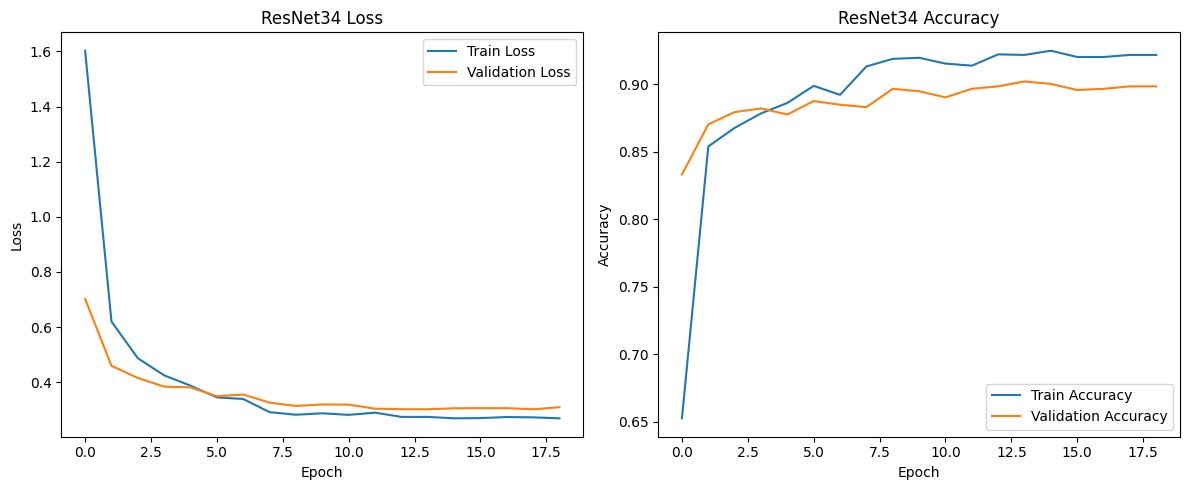

Saved training history to ResNet34_training_history.png
Saved ResNet34 model


In [41]:
resnet34_optimizer = optim.Adam(resnet34.fc.parameters(), lr=0.001)
resnet34_criterion = nn.CrossEntropyLoss()
resnet34_scheduler = optim.lr_scheduler.StepLR(resnet34_optimizer, step_size=7, gamma=0.1)

trained_resnet34, resnet34_history = train_model(
    resnet34,
    "ResNet34",
    resnet34_criterion,
    resnet34_optimizer,
    resnet34_scheduler,
    num_epochs=25
)

# Save model
torch.save(trained_resnet34.state_dict(), 'resnet34.pth')
print("Saved ResNet34 model")

Here I am training the RestNet34 model using the training function i have defined above. Plotting loss and accuracy over epoch.

### Training ResNet50


Training ResNet50 model...

Epoch 1/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.04it/s, loss=0.76]


Train Loss: 1.6128 | Acc: 0.7300
Val Loss: 0.7164 | Acc: 0.8730
Validation loss improved. Saving model...

Epoch 2/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  5.98it/s, loss=0.451]


Train Loss: 0.5396 | Acc: 0.8987
Val Loss: 0.4477 | Acc: 0.9011
Validation loss improved. Saving model...

Epoch 3/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  5.90it/s, loss=0.349]


Train Loss: 0.3746 | Acc: 0.9154
Val Loss: 0.3573 | Acc: 0.9102
Validation loss improved. Saving model...

Epoch 4/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.03it/s, loss=0.283]


Train Loss: 0.2992 | Acc: 0.9316
Val Loss: 0.3234 | Acc: 0.9074
Validation loss improved. Saving model...

Epoch 5/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.05it/s, loss=0.285]


Train Loss: 0.2638 | Acc: 0.9360
Val Loss: 0.3031 | Acc: 0.9165
Validation loss improved. Saving model...

Epoch 6/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  5.97it/s, loss=0.248]


Train Loss: 0.2257 | Acc: 0.9434
Val Loss: 0.2956 | Acc: 0.9156
Validation loss improved. Saving model...

Epoch 7/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.07it/s, loss=0.262]


Train Loss: 0.2052 | Acc: 0.9442
Val Loss: 0.2796 | Acc: 0.9183
Validation loss improved. Saving model...

Epoch 8/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.05it/s, loss=0.276]


Train Loss: 0.1839 | Acc: 0.9572
Val Loss: 0.2696 | Acc: 0.9265
Validation loss improved. Saving model...

Epoch 9/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.05it/s, loss=0.268]


Train Loss: 0.1701 | Acc: 0.9615
Val Loss: 0.2732 | Acc: 0.9174
No improvement for 1/5 epochs

Epoch 10/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.00it/s, loss=0.265]


Train Loss: 0.1696 | Acc: 0.9607
Val Loss: 0.2748 | Acc: 0.9220
No improvement for 2/5 epochs

Epoch 11/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.14it/s, loss=0.284]


Train Loss: 0.1791 | Acc: 0.9611
Val Loss: 0.2662 | Acc: 0.9211
Validation loss improved. Saving model...

Epoch 12/25
----------


Validation: 100%|████████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.18it/s, loss=0.3]


Train Loss: 0.1706 | Acc: 0.9572
Val Loss: 0.2701 | Acc: 0.9211
No improvement for 1/5 epochs

Epoch 13/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.28it/s, loss=0.292]


Train Loss: 0.1655 | Acc: 0.9625
Val Loss: 0.2735 | Acc: 0.9192
No improvement for 2/5 epochs

Epoch 14/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.20it/s, loss=0.277]


Train Loss: 0.1649 | Acc: 0.9631
Val Loss: 0.2706 | Acc: 0.9183
No improvement for 3/5 epochs

Epoch 15/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.10it/s, loss=0.281]


Train Loss: 0.1668 | Acc: 0.9580
Val Loss: 0.2671 | Acc: 0.9211
No improvement for 4/5 epochs

Epoch 16/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.15it/s, loss=0.281]


Train Loss: 0.1640 | Acc: 0.9627
Val Loss: 0.2652 | Acc: 0.9192
Validation loss improved. Saving model...

Epoch 17/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.05it/s, loss=0.282]


Train Loss: 0.1561 | Acc: 0.9660
Val Loss: 0.2664 | Acc: 0.9183
No improvement for 1/5 epochs

Epoch 18/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.21it/s, loss=0.276]


Train Loss: 0.1599 | Acc: 0.9629
Val Loss: 0.2587 | Acc: 0.9201
Validation loss improved. Saving model...

Epoch 19/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.11it/s, loss=0.305]


Train Loss: 0.1681 | Acc: 0.9590
Val Loss: 0.2737 | Acc: 0.9183
No improvement for 1/5 epochs

Epoch 20/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.17it/s, loss=0.284]


Train Loss: 0.1613 | Acc: 0.9642
Val Loss: 0.2673 | Acc: 0.9220
No improvement for 2/5 epochs

Epoch 21/25
----------


Validation: 100%|██████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.32it/s, loss=0.261]


Train Loss: 0.1644 | Acc: 0.9636
Val Loss: 0.2659 | Acc: 0.9229
No improvement for 3/5 epochs

Epoch 22/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.20it/s, loss=0.28]


Train Loss: 0.1606 | Acc: 0.9642
Val Loss: 0.2731 | Acc: 0.9192
No improvement for 4/5 epochs

Epoch 23/25
----------


Validation: 100%|███████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.09it/s, loss=0.27]


Train Loss: 0.1582 | Acc: 0.9619
Val Loss: 0.2603 | Acc: 0.9201
No improvement for 5/5 epochs
Early stopping after 23 epochs


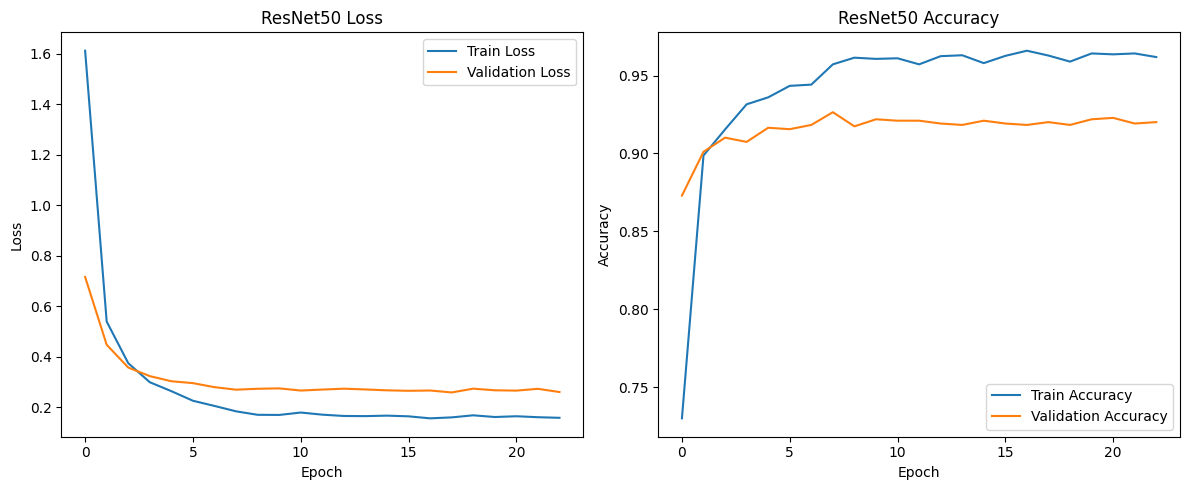

Saved training history to ResNet50_training_history.png
Saved ResNet50 model


In [42]:
# Training ResNet50 Model
resnet50_optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)
resnet50_criterion = nn.CrossEntropyLoss()
resnet50_scheduler = optim.lr_scheduler.StepLR(resnet50_optimizer, step_size=7, gamma=0.1)

trained_resnet50, resnet50_history = train_model(
    resnet50,
    "ResNet50",
    resnet50_criterion,
    resnet50_optimizer,
    resnet50_scheduler,
    num_epochs=25
)

# Save model
torch.save(trained_resnet50.state_dict(), 'resnet50.pth')
print("Saved ResNet50 model")

Here I am training the RestNet50 model using the training function i have defined above. Plotting loss and accuracy over epoch.

### Evaluation On Test Data

In [43]:
# Evaluation Functions for test dataS
def evaluate_model(model, model_name, test_loader):
    print(f"\nEvaluating {model_name} on test set...")
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_dataset)
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    print(f"Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    print(f"Saved confusion matrix to {model_name}_confusion_matrix.png")
    
    return test_loss, accuracy

def visualize_predictions(model, dataloader, class_names, model_name, num_images=12):
    print(f"Visualizing predictions for {model_name}...")
    model.eval()
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'{model_name} Predictions', fontsize=16)
    
    for i in range(min(num_images, images.size(0))):
        ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
        img = images.cpu().data[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}', color=color)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{model_name}_predictions.png')
    plt.show()
    print(f"Saved predictions to {model_name}_predictions.png")


### Evaluating Custom CNN


Evaluating Custom_CNN on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.50it/s]
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Test Loss: 2.4405 | Accuracy: 0.3046

Classification Report:
                            precision    recall  f1-score   support

                abyssinian     0.2778    0.3333    0.3030        30
          american_bulldog     0.2258    0.2188    0.2222        32
 american_pit_bull_terrier     0.0000    0.0000    0.0000        36
              basset_hound     0.2833    0.5862    0.3820        29
                    beagle     0.1364    0.1034    0.1176        29
                    bengal     0.4222    0.6129    0.5000        31
                    birman     0.3947    0.5172    0.4478        29
                    bombay     0.3519    0.7308    0.4750        26
                     boxer     0.0000    0.0000    0.0000        38
         british_shorthair     0.2250    0.3913    0.2857        23
                 chihuahua     0.0000    0.0000    0.0000        29
              egyptian_mau     0.4762    0.6897    0.5634        29
    english_cocker_spaniel     0.5000    0.0690    0.1

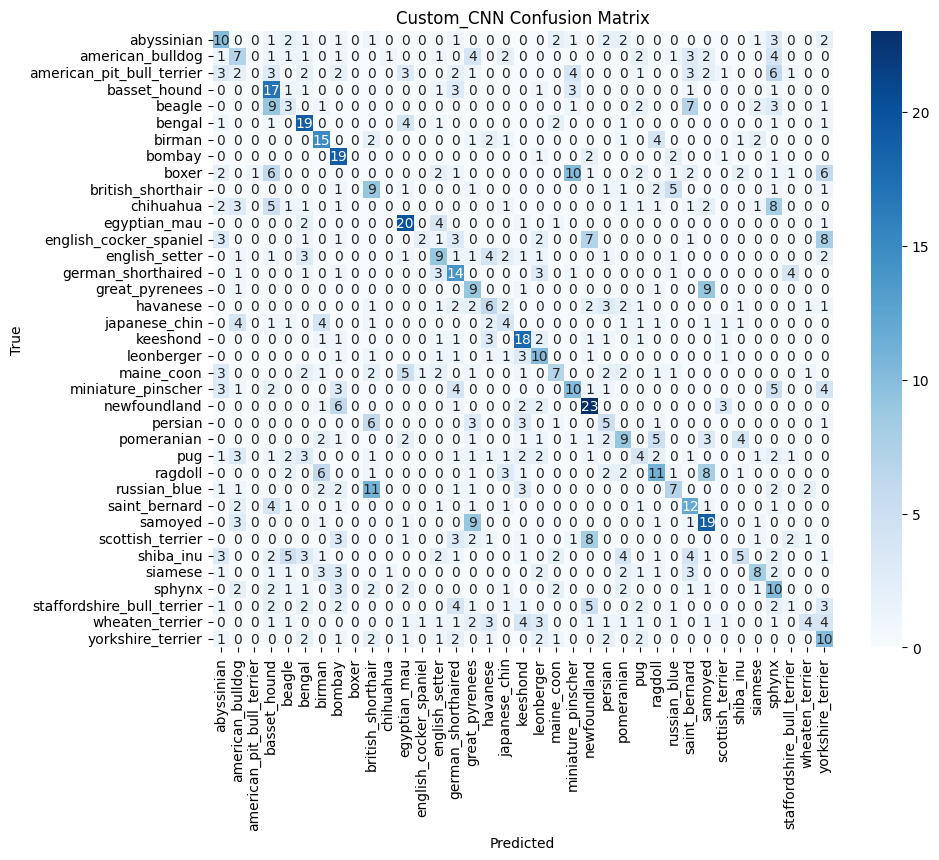

Saved confusion matrix to Custom_CNN_confusion_matrix.png
Visualizing predictions for Custom_CNN...


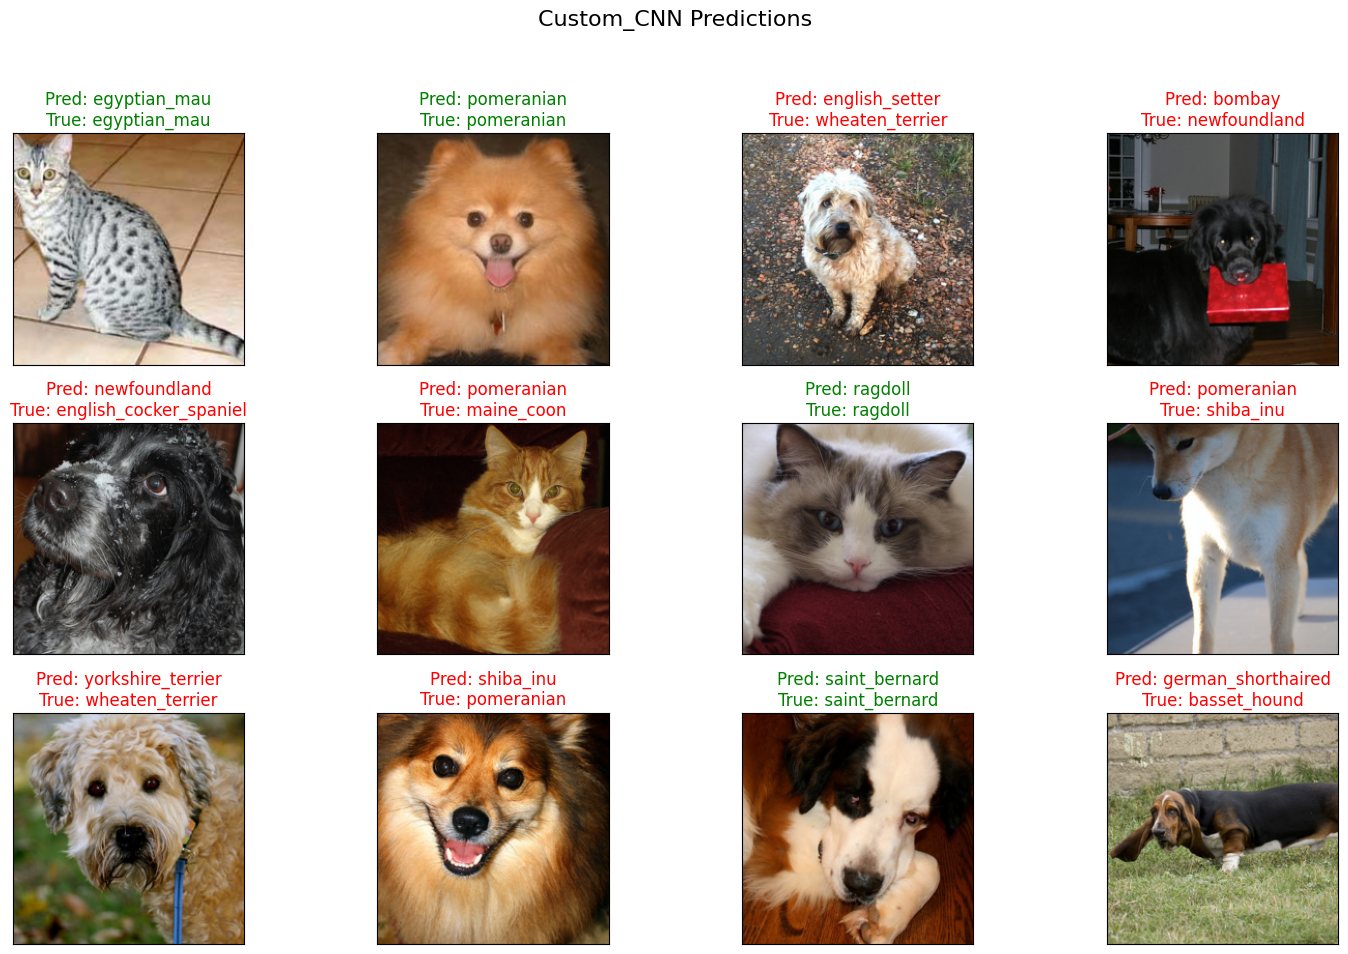

Saved predictions to Custom_CNN_predictions.png


In [44]:
#  Evaluate the custom CNN metrics
cnn_test_loss, cnn_accuracy = evaluate_model(trained_cnn, "Custom_CNN", test_loader)
visualize_predictions(trained_cnn, test_loader, class_names, "Custom_CNN")


### Evaluating ResNet18


Evaluating ResNet on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.48it/s]


Test Loss: 0.3384 | Accuracy: 0.8976

Classification Report:
                            precision    recall  f1-score   support

                abyssinian     0.7500    0.9000    0.8182        30
          american_bulldog     0.7879    0.8125    0.8000        32
 american_pit_bull_terrier     0.8710    0.7500    0.8060        36
              basset_hound     0.8889    0.8276    0.8571        29
                    beagle     0.9000    0.9310    0.9153        29
                    bengal     0.7838    0.9355    0.8529        31
                    birman     0.8400    0.7241    0.7778        29
                    bombay     0.8333    0.9615    0.8929        26
                     boxer     0.9231    0.9474    0.9351        38
         british_shorthair     0.8148    0.9565    0.8800        23
                 chihuahua     0.9286    0.8966    0.9123        29
              egyptian_mau     0.9583    0.7931    0.8679        29
    english_cocker_spaniel     0.8710    0.9310    0.9

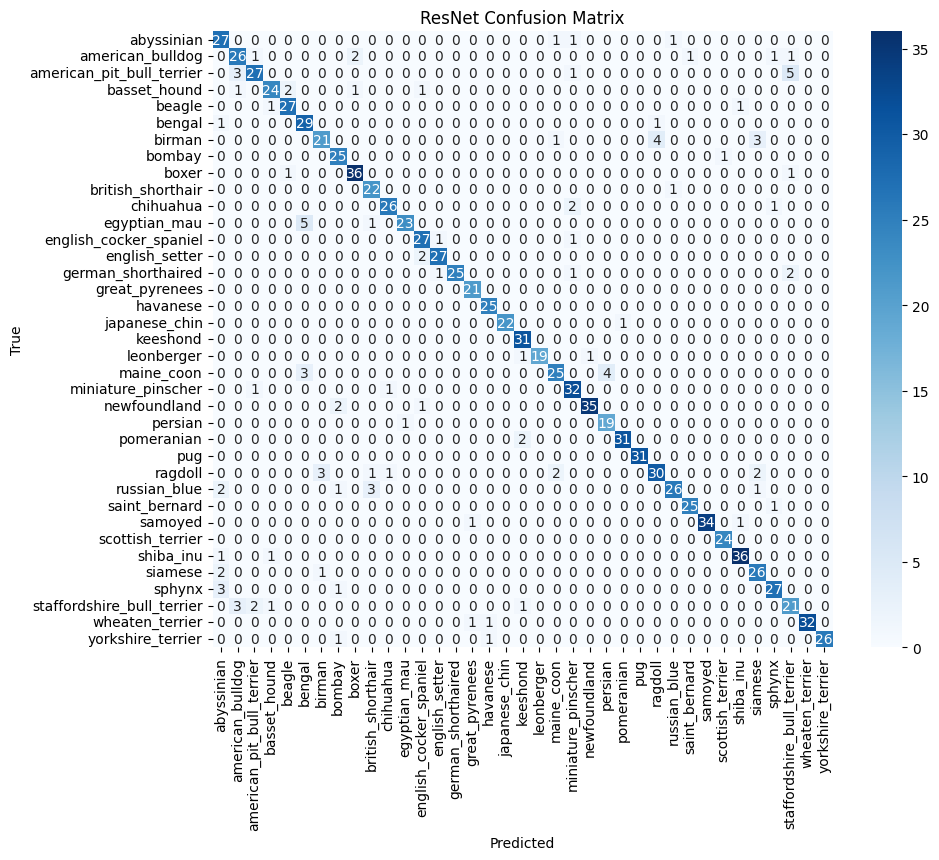

Saved confusion matrix to ResNet_confusion_matrix.png
Visualizing predictions for ResNet...


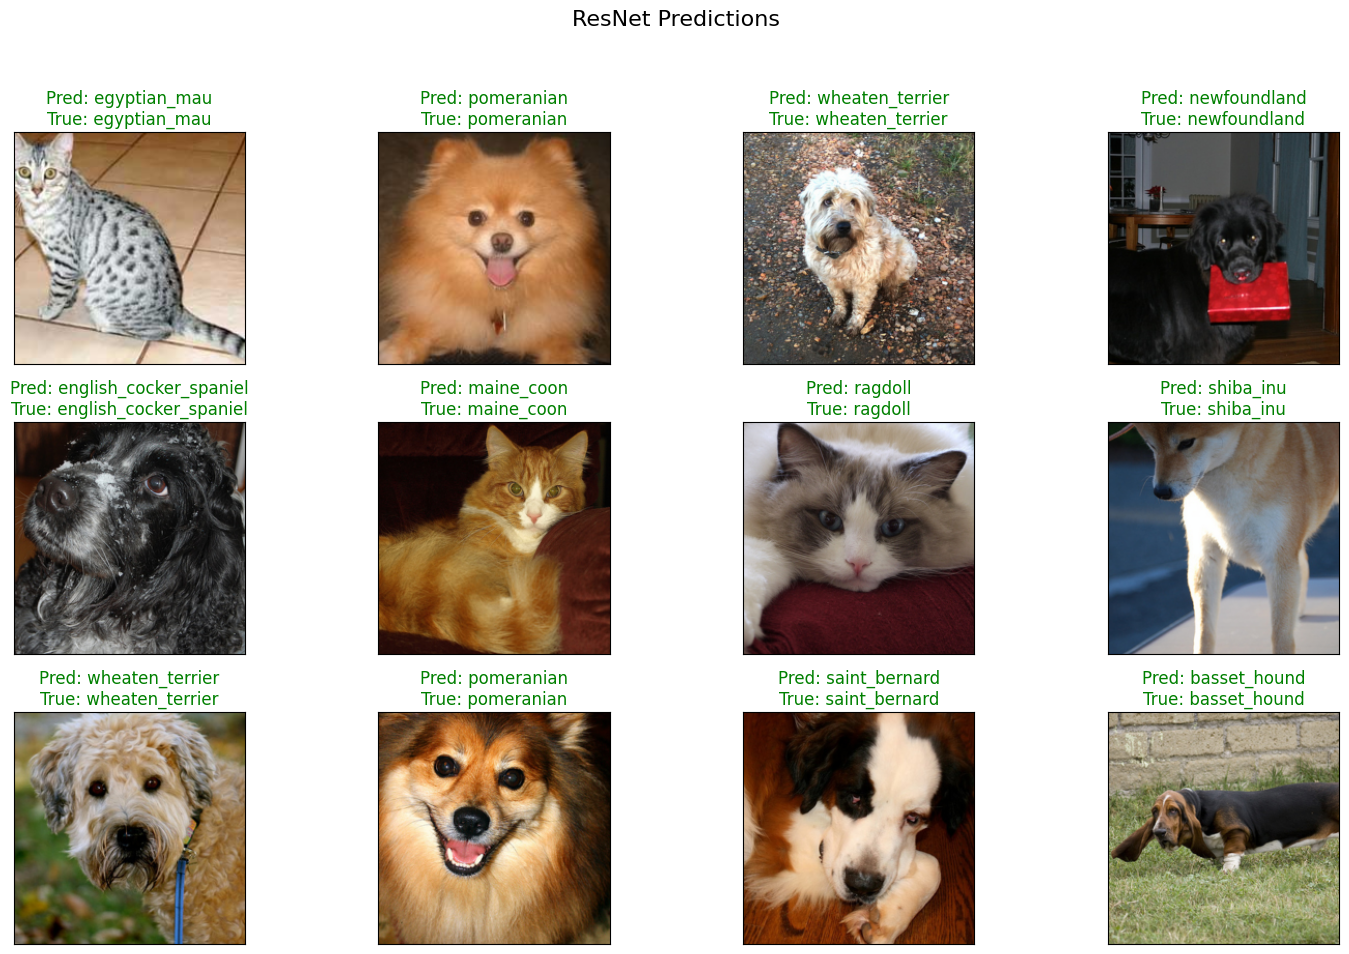

Saved predictions to ResNet_predictions.png


In [50]:
# Evaluating ResNet18 metrics
resnet_test_loss, resnet_accuracy = evaluate_model(trained_resnet, "ResNet", test_loader)
visualize_predictions(trained_resnet, test_loader, class_names, "ResNet")

Finnaly here i have evaluated the model on test data and shown classification report which tells us the overall performance of our model for  each class of pets in our dataset, also the confusion matrix to see how many of the predictions were made correct or wrong. Finally some sample pictures of the predictions with the true labels.

### Evaluating ResNet34


Evaluating ResNet34 on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.43it/s]


Test Loss: 0.2882 | Accuracy: 0.9057

Classification Report:
                            precision    recall  f1-score   support

                abyssinian     0.8235    0.9333    0.8750        30
          american_bulldog     0.7368    0.8750    0.8000        32
 american_pit_bull_terrier     0.8710    0.7500    0.8060        36
              basset_hound     0.9032    0.9655    0.9333        29
                    beagle     0.9630    0.8966    0.9286        29
                    bengal     0.8889    0.7742    0.8276        31
                    birman     0.8077    0.7241    0.7636        29
                    bombay     0.8966    1.0000    0.9455        26
                     boxer     0.9189    0.8947    0.9067        38
         british_shorthair     0.8400    0.9130    0.8750        23
                 chihuahua     0.9200    0.7931    0.8519        29
              egyptian_mau     0.8438    0.9310    0.8852        29
    english_cocker_spaniel     0.9333    0.9655    0.9

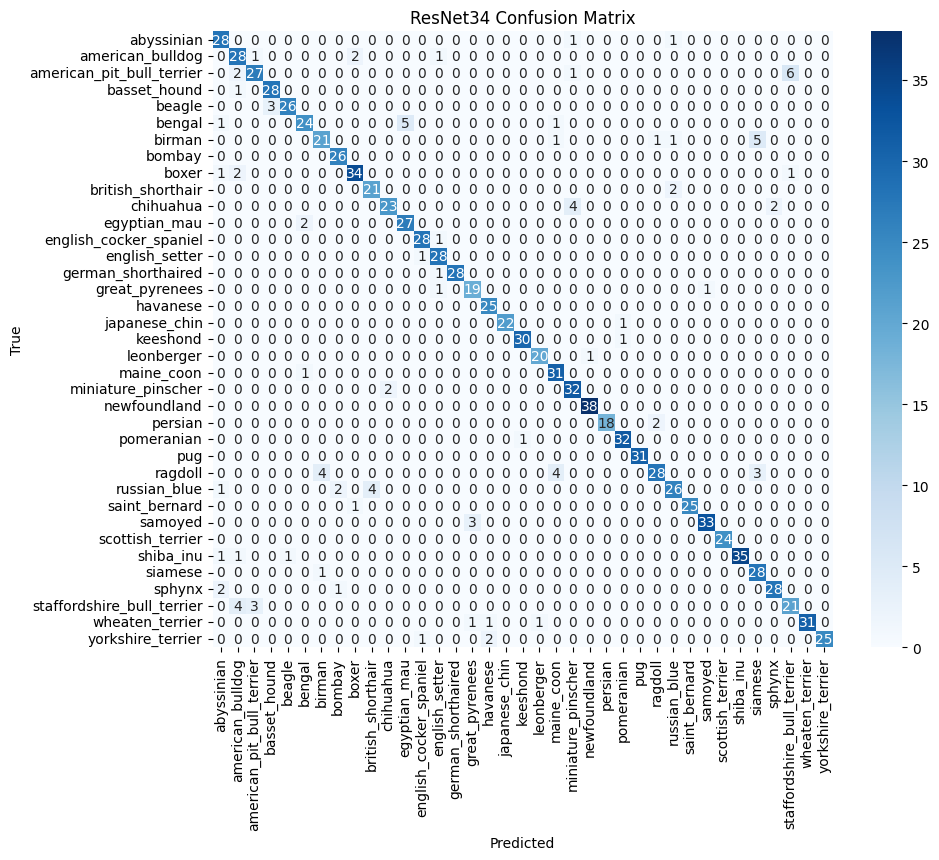

Saved confusion matrix to ResNet34_confusion_matrix.png
Visualizing predictions for ResNet34...


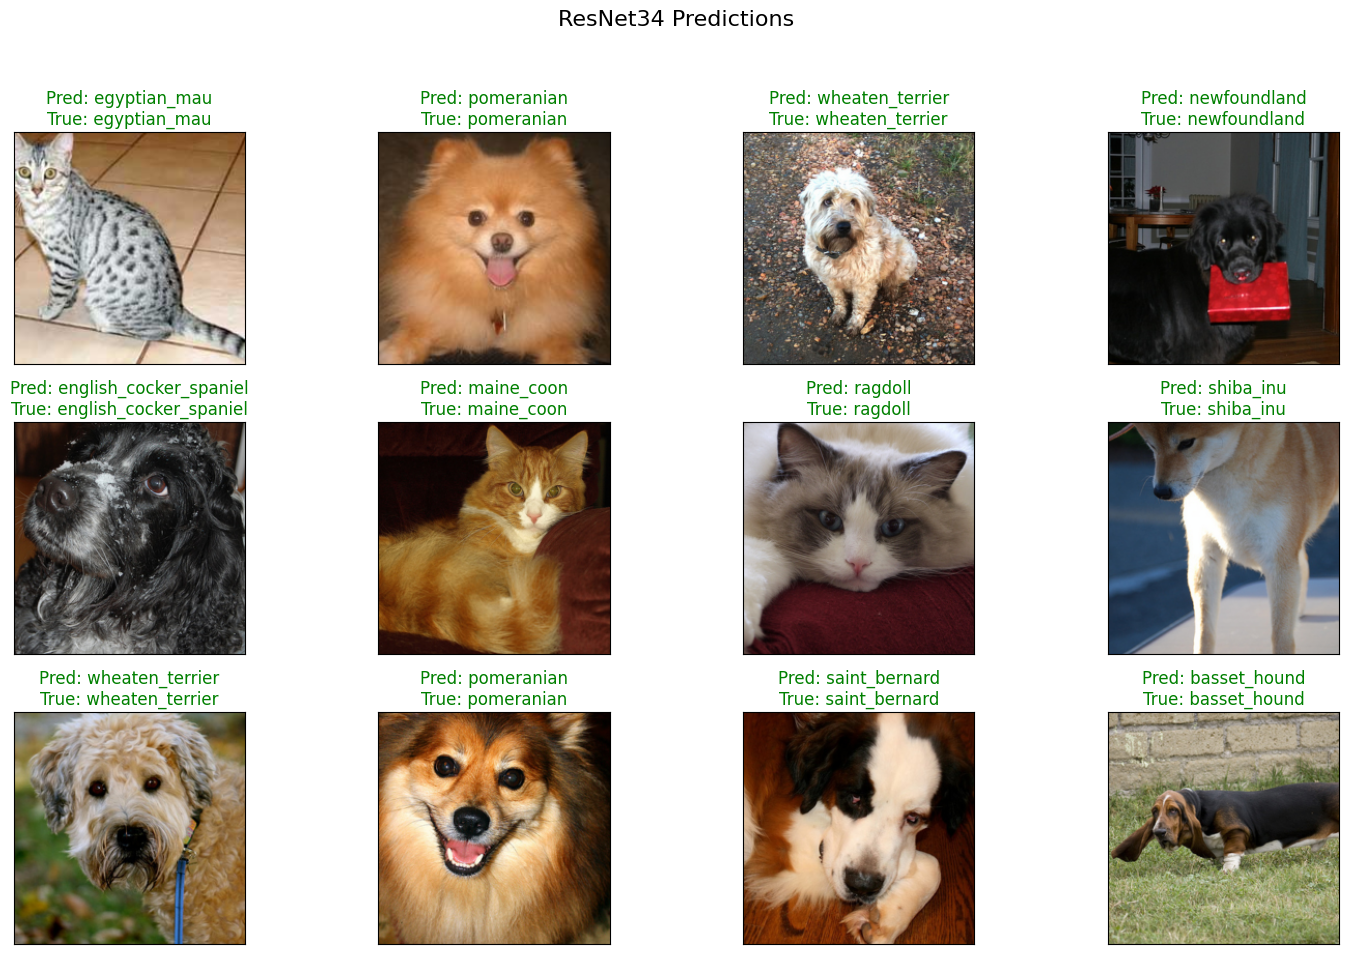

Saved predictions to ResNet34_predictions.png


In [46]:
resnet34_test_loss, resnet34_accuracy = evaluate_model(trained_resnet34, "ResNet34", test_loader)
visualize_predictions(trained_resnet34, test_loader, class_names, "ResNet34")

Finnaly here i have evaluated the model on test data and shown classification report which tells us the overall performance of our model for  each class of pets in our dataset, also the confusion matrix to see how many of the predictions were made correct or wrong. Finally some sample pictures of the predictions with the true labels.

### Evaluating ResNet50


Evaluating ResNet50 on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.79it/s]


Test Loss: 0.2508 | Accuracy: 0.9238

Classification Report:
                            precision    recall  f1-score   support

                abyssinian     0.8125    0.8667    0.8387        30
          american_bulldog     0.8750    0.8750    0.8750        32
 american_pit_bull_terrier     0.7778    0.7778    0.7778        36
              basset_hound     0.9655    0.9655    0.9655        29
                    beagle     0.9032    0.9655    0.9333        29
                    bengal     0.8667    0.8387    0.8525        31
                    birman     0.8571    0.8276    0.8421        29
                    bombay     0.9286    1.0000    0.9630        26
                     boxer     0.9730    0.9474    0.9600        38
         british_shorthair     0.7586    0.9565    0.8462        23
                 chihuahua     0.9615    0.8621    0.9091        29
              egyptian_mau     0.8125    0.8966    0.8525        29
    english_cocker_spaniel     0.9062    1.0000    0.9

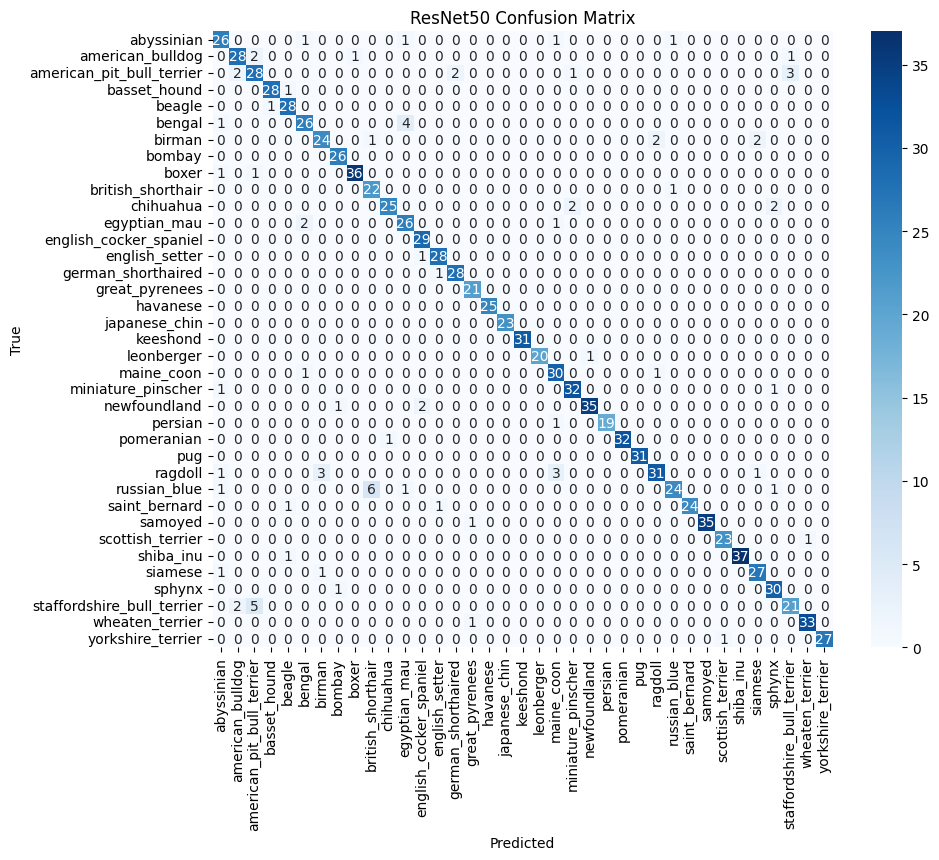

Saved confusion matrix to ResNet50_confusion_matrix.png
Visualizing predictions for ResNet50...


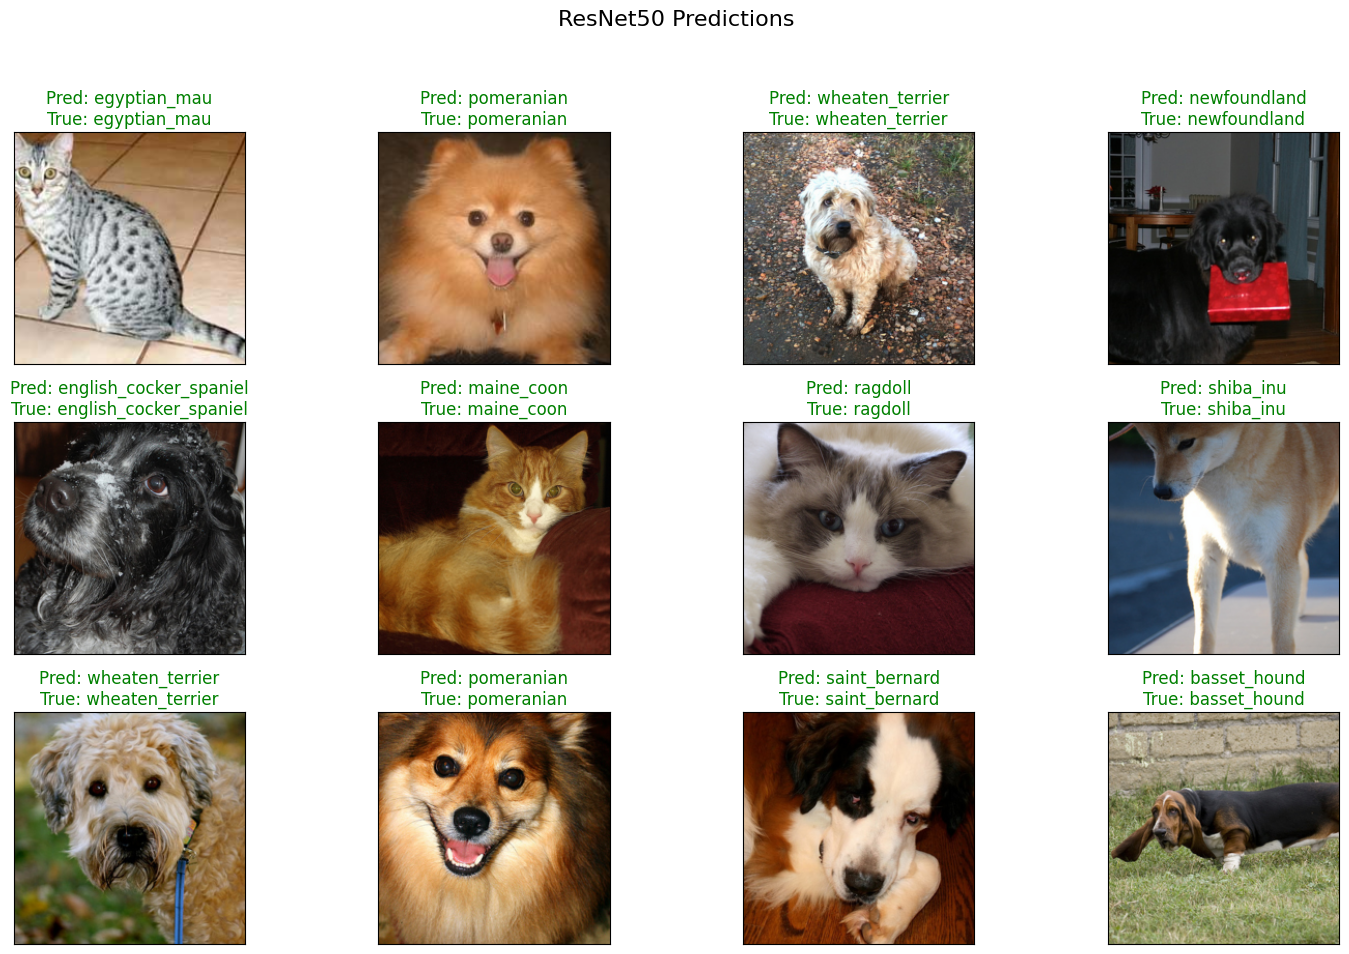

Saved predictions to ResNet50_predictions.png


In [47]:
# Evaluating ResNet50 metrics
resnet50_test_loss, resnet50_accuracy = evaluate_model(trained_resnet50, "ResNet50", test_loader)
visualize_predictions(trained_resnet50, test_loader, class_names, "ResNet50")

Finnaly here i have evaluated the model on test data and shown classification report which tells us the overall performance of our model for  each class of pets in our dataset, also the confusion matrix to see how many of the predictions were made correct or wrong. Finally some sample pictures of the predictions with the true labels.

### Comparison Of All Models

Custom CNN Test Accuracy: 0.3046
ResNet18 Test Accuracy: 0.8976
ResNet34 Test Accuracy: 0.9057
ResNet50 Test Accuracy: 0.9238


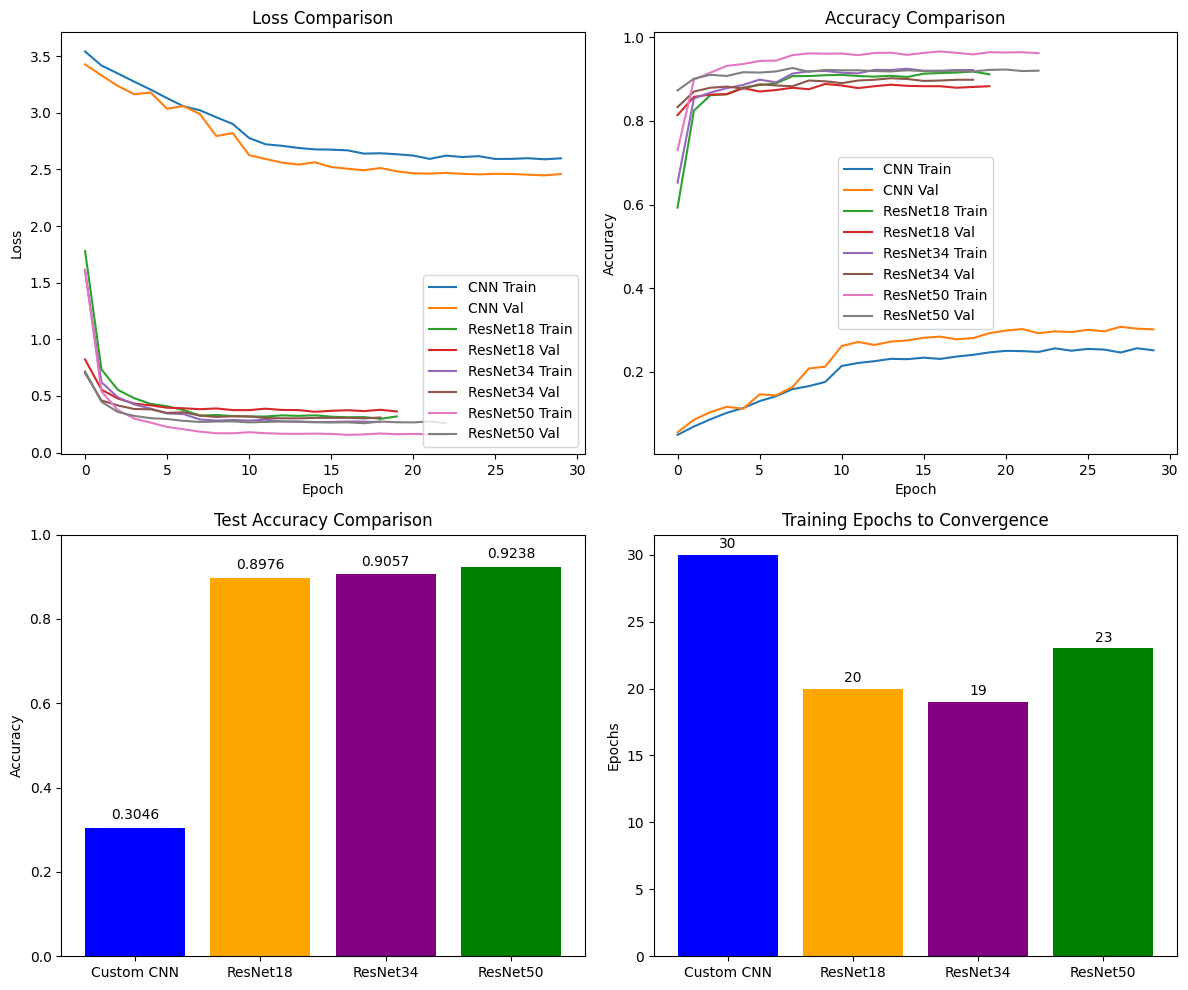

Saved model comparison chart to 'model_comparison.png'


In [56]:
# Model Comparison 
print(f"Custom CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"ResNet18 Test Accuracy: {resnet_accuracy:.4f}")
print(f"ResNet34 Test Accuracy: {resnet34_accuracy:.4f}")
print(f"ResNet50 Test Accuracy: {resnet50_accuracy:.4f}")

# Compare training histories
plt.figure(figsize=(12, 10))

# Loss comparison
plt.subplot(2, 2, 1)
plt.plot(cnn_history['train_loss'], label='CNN Train')
plt.plot(cnn_history['val_loss'], label='CNN Val')
plt.plot(resnet_history['train_loss'], label='ResNet18 Train')
plt.plot(resnet_history['val_loss'], label='ResNet18 Val')
plt.plot(resnet34_history['train_loss'], label='ResNet34 Train')
plt.plot(resnet34_history['val_loss'], label='ResNet34 Val')
plt.plot(resnet50_history['train_loss'], label='ResNet50 Train')
plt.plot(resnet50_history['val_loss'], label='ResNet50 Val')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(2, 2, 2)
plt.plot(cnn_history['train_acc'], label='CNN Train')
plt.plot(cnn_history['val_acc'], label='CNN Val')
plt.plot(resnet_history['train_acc'], label='ResNet18 Train')
plt.plot(resnet_history['val_acc'], label='ResNet18 Val')
plt.plot(resnet34_history['train_acc'], label='ResNet34 Train')
plt.plot(resnet34_history['val_acc'], label='ResNet34 Val')
plt.plot(resnet50_history['train_acc'], label='ResNet50 Train')
plt.plot(resnet50_history['val_acc'], label='ResNet50 Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Final accuracy
plt.subplot(2, 2, 3)
models = [ 'Custom CNN','ResNet18', 'ResNet34', 'ResNet50']
accuracies = [ cnn_accuracy, resnet_accuracy, resnet34_accuracy, resnet50_accuracy]
colors = [ 'blue', 'orange', 'purple', 'green']
plt.bar(models, accuracies, color=colors)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

# Training epochs
plt.subplot(2, 2, 4)
training_epochs = [
    len(cnn_history['train_loss']),
    len(resnet_history['train_loss']),
    len(resnet34_history['train_loss']),
    len(resnet50_history['train_loss'])
]
plt.bar(models, training_epochs, color=colors)
plt.title('Training Epochs to Convergence')
plt.ylabel('Epochs')
for i, v in enumerate(training_epochs):
    plt.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
print("Saved model comparison chart to 'model_comparison.png'")

Finnally towards the end I have made a comparison between all the models i have used, their respective epochs to convergence and loss and accuracy. As we can see ResNet50 has outperformed all the models which we have used.